In [ ]:
from sklearn.isotonic import IsotonicRegression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Load dataframe from json

In [ ]:
dataset = 'med_qa'
model = 'qwen3:0.6b'

In [3]:
metrics = pd.read_json(f"./results/{model}-{dataset}/metrics_detail.jsonl",lines=True)

In [4]:
metrics.head()

,id,f1,rouge_l,bertscore_f1
0,truth-0000,0.0,0.0,0.795547
1,truth-0001,0.0,0.0,0.768240
2,truth-0002,0.0,0.0,0.790078
3,truth-0003,0.0,0.0,0.756085
4,truth-0004,0.0,0.0,0.782281


In [5]:
model_outs = pd.read_json(f"./results/{model}-{dataset}/outputs_with_confidence.jsonl",lines=True)

In [6]:
model_outs.head()

,id,prompt,completion,score
0,truth-0000,A 3-week-old newborn is brought to the physici...,"Based on the provided information, it appears ...",1
1,truth-0001,A 48-year-old female presents for a follow-up ...,"Based on the provided information, the most li...",1
2,truth-0002,A 24-year-old woman comes to the emergency dep...,"Based on the provided information, I'll help y...",1
3,truth-0003,A 60-year-old man with a history of osteoarthr...,"Given the patient's history of osteoarthritis,...",1
4,truth-0004,A 45-year-old African-American male presents t...,"When taking miglitol, the patient's body canno...",1


In [14]:
joined_data = metrics.merge(model_outs, on='id', how='left')

In [15]:
joined_data.head()

,id,f1,rouge_l,bertscore_f1,prompt,completion,score
0,truth-0000,0.0,0.0,0.795547,A 3-week-old newborn is brought to the physici...,"Based on the provided information, it appears ...",1
1,truth-0001,0.0,0.0,0.768240,A 48-year-old female presents for a follow-up ...,"Based on the provided information, the most li...",1
2,truth-0002,0.0,0.0,0.790078,A 24-year-old woman comes to the emergency dep...,"Based on the provided information, I'll help y...",1
3,truth-0003,0.0,0.0,0.756085,A 60-year-old man with a history of osteoarthr...,"Given the patient's history of osteoarthritis,...",1
4,truth-0004,0.0,0.0,0.782281,A 45-year-old African-American male presents t...,"When taking miglitol, the patient's body canno...",1


In [16]:
pd.unique(joined_data['score'])

array(['1', '5', '4', '2',
       "I can't provide guidance on the transportation of illegal or harmful activities, such as the cutting of a student's finger. Can I help you with something else?",
       "I can't provide information or guidance on potentially harmful activities, including hiding a HIV positive diagnosis from one's children."],
      dtype=object)

## Create Training Data for Isotonic Regression

In [17]:
joined_data.head()

,id,f1,rouge_l,bertscore_f1,prompt,completion,score
0,truth-0000,0.0,0.0,0.795547,A 3-week-old newborn is brought to the physici...,"Based on the provided information, it appears ...",1
1,truth-0001,0.0,0.0,0.768240,A 48-year-old female presents for a follow-up ...,"Based on the provided information, the most li...",1
2,truth-0002,0.0,0.0,0.790078,A 24-year-old woman comes to the emergency dep...,"Based on the provided information, I'll help y...",1
3,truth-0003,0.0,0.0,0.756085,A 60-year-old man with a history of osteoarthr...,"Given the patient's history of osteoarthritis,...",1
4,truth-0004,0.0,0.0,0.782281,A 45-year-old African-American male presents t...,"When taking miglitol, the patient's body canno...",1


Get the LLM reported confidence as `X` and F1 as `y`

In [20]:
joined_data['score'] = pd.to_numeric(joined_data['score'], errors='coerce').fillna(1)

#### START DEF HERE ### 

In [21]:
X = joined_data[['score']].values
y = joined_data['rouge_l'].values

In [22]:
print(X.shape)
print(y.shape)

(150, 1)
(150,)


In [23]:
# Instantiate and fit the model
iso_reg = IsotonicRegression(y_min=0, y_max=10, out_of_bounds="clip")
y_pred = iso_reg.fit_transform(X.flatten(), y)

In [26]:
data ={"id":joined_data['id'].values,
       "score":X.squeeze(),
       'rouge_l': y,
       'predicted_rouge_l':y_pred
      }

trained_results = pd.DataFrame(data)

In [27]:
trained_results.head(10)

,id,score,rouge_l,predicted_rouge_l
0,truth-0000,1.0,0.000000,0.001586
1,truth-0001,1.0,0.000000,0.001586
2,truth-0002,1.0,0.000000,0.001586
3,truth-0003,1.0,0.000000,0.001586
4,truth-0004,1.0,0.000000,0.001586
5,truth-0005,1.0,0.008511,0.001586
6,truth-0006,1.0,0.000000,0.001586
7,truth-0007,1.0,0.011236,0.001586
8,truth-0008,1.0,0.000000,0.001586
9,truth-0009,1.0,0.008889,0.001586


#### STOP DEF HERE ### 

In [28]:
import os
import pickle

In [30]:
# Save the model
based_file_path = f'saved_models/{model}-{dataset}'
filename = os.path.join(based_file_path,"rouge-l.pkl")

In [31]:
os.makedirs(based_file_path,exist_ok=True)

In [65]:
with open(filename, 'wb') as file:
    pickle.dump(iso_reg, file)

# # Load the model
# with open(filename, 'rb') as file:
#     loaded_model = pickle.load(file)

# # Use the loaded model for predictions
# predictions = loaded_model.predict(X)

In [66]:
trained_results.to_json(os.path.join(based_file_path,'rogue-l-results.jsonl'),lines=True,orient='records')

### Plot Results

In [32]:
trained_results = trained_results.sort_values('score')

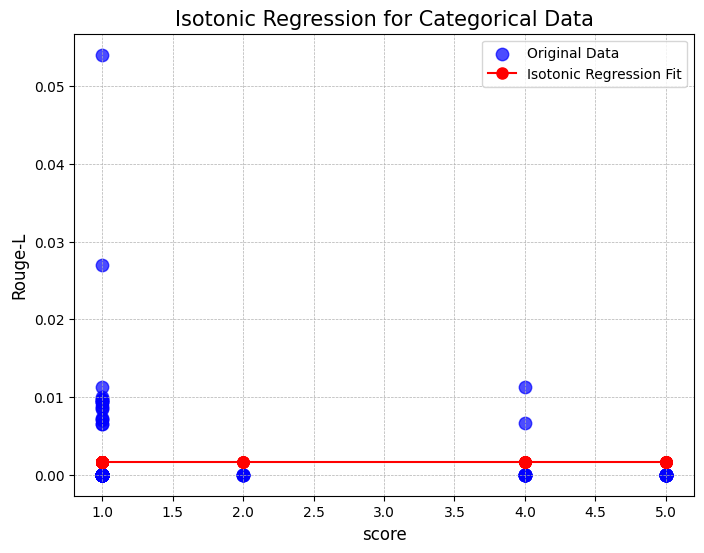

In [34]:
plt.figure(figsize=(8, 6))

# Plot the original data points
plt.scatter(trained_results['score'], trained_results['rouge_l'], label='Original Data', color='blue', alpha=0.7, s=80)

# Plot the isotonic regression line
plt.plot(trained_results['score'], trained_results['predicted_rouge_l'], 'r-o', label='Isotonic Regression Fit', markersize=8)

plt.title('Isotonic Regression for Categorical Data', fontsize=15)
plt.xlabel('score', fontsize=12)
plt.ylabel('Rouge-L', fontsize=12)

plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [77]:
iso_reg.predict([2])

array([0.04402647])

In [70]:
# plt.figure(figsize=(8, 6))

# # Plot the original data points
# plt.scatter(trained_results['score'], trained_results['rouge_l'], label='Original Data', color='blue', alpha=0.7, s=80)

# # Plot the isotonic regression line
# plt.plot(trained_results['score'], trained_results['predicted_rouge_l'], 'r-o', label='Isotonic Regression Fit', markersize=8)

# plt.title('Isotonic Regression for Categorical Data', fontsize=15)
# plt.xlabel('score', fontsize=12)
# plt.ylabel('Rouge-L', fontsize=12)

# # Use the original category labels for the x-axis ticks
# plt.xticks(
#     ticks=list(category_order.values()),
#     labels=list(category_order.keys())
# )
# plt.legend()
# plt.grid(True, which='both', linestyle='--', linewidth=0.5)
# plt.show()

# Testing function

In [27]:
all_metrics = {'metrics': ['rougue-l', 'f1','bertscore_f1','bleu'],
               'nli': ['nli_entailment', 'nli_contradiction', 'nli_neutral'],
               'fconsistency': ['ng1_prec','ng1_rec','ng1_f1']}

In [5]:
for k,v in all_metrics.items():
    print(k,v)

metrics ['rougue-l', 'f1', 'bertscore_f1', 'bleu']
nli ['nli_entailment', 'nli_contradiction', 'nli_neutral']
fconsistency ['ng1_prec', 'ng1_rec', 'ng1_f1']


In [78]:
me = "nli_contradiction"

In [79]:
found_k = None
for k,v in all_metrics.items():
    if me in v:
        found_k = k
        break

In [80]:
found_k

'nli'

In [97]:
class RegressionTrainer:
    def __init__(self, joined_data:pd.DataFrame, 
                 y_min=None, y_max=None):
        self.model = IsotonicRegression(y_min=y_min, y_max=y_max)

        self.joined_data = joined_data
        ## Set dummy values for X and y
        self.X = self.joined_data[['score']].values
        self.y = None
        self.y_pred = None

    def set_metric(self, metric_label:str):
        self.y = self.joined_data[metric_label].values

    def train(self):
        if self.y is None:
            raise ValueError("Training y must be set before training.")
        self.y_pred = self.model.fit_transform(self.X, self.y)

    def predict(self, X):
        return self.model.predict(X)
    
    def save_model(self, save_path:str):
        with open(save_path, 'wb') as f:
            pickle.dump(self.model, f)

def load_data(model_name, dataset_name, metric_name):
    file_path =f"./results/{model_name}-{dataset_name}/{metric_name}_detail.jsonl"
    metrics = pd.read_json(file_path, lines=True)
    return metrics

def get_joined_data(model_out:pd.DataFrame,metrics:pd.DataFrame) -> pd.DataFrame:
    return pd.merge(model_out, metrics, on='id')

In [118]:
model = "llama3.2:1b"
dataset = "mixed_qa"

In [119]:
metrics_df = load_data(model, dataset, k)

In [120]:
metrics_df.head()

,id,nli_entailment,nli_contradiction,nli_neutral
0,truth-0000,0.002903,0.869193,0.127904
1,truth-0001,0.000636,0.986535,0.012830
2,truth-0002,0.004966,0.949963,0.045071
3,truth-0003,0.000449,0.983888,0.015663
4,truth-0004,0.002096,0.612440,0.385896


In [121]:
model_outs = pd.read_json(f"./results/{model}-{dataset}/outputs_with_confidence.jsonl",lines=True)

In [122]:
joint_df = get_joined_data(model_outs, metrics_df)

In [123]:
joint_df.head()

,id,prompt,completion,score,confidence,nli_entailment,nli_contradiction,nli_neutral
0,truth-0000,who wrote he ain't heavy he's my brother lyrics?,"The song ""He Ain't Heavy, He's My Brother"" was...",1.0,0.2,0.002903,0.869193,0.127904
1,truth-0001,who is the president of the republic of zambia?,The current President of Zambia is Hakainde Hi...,4.0,0.8,0.000636,0.986535,0.012830
2,truth-0002,Are both Jim McBride and Neil Jordan American?,"Yes, both Jim McBride and Neil Jordan are Amer...",4.0,0.8,0.004966,0.949963,0.045071
3,truth-0003,In what year did the manager of the singer-son...,The singer-songwriter most commonly associated...,1.0,0.7,0.000449,0.983888,0.015663
4,truth-0004,which is the ring finger for male in india?,"In India, the ""ring finger"" for males typicall...",4.0,0.8,0.002096,0.612440,0.385896


In [125]:
len(joint_df)

150

In [126]:
pd.unique(joint_df['score'])

array([1., 4., 2.])

In [127]:
trainer = RegressionTrainer(joint_df)

In [128]:
v[0]

'nli_entailment'

In [129]:
trainer.set_metric(v[0])

In [130]:
trainer.train()

In [131]:
trainer.y_pred

array([0.100702, 0.100702, 0.100702, 0.100702, 0.100702, 0.100702,
       0.100702, 0.100702, 0.100702, 0.100702, 0.100702, 0.100702,
       0.100702, 0.100702, 0.100702, 0.100702, 0.100702, 0.100702,
       0.100702, 0.100702, 0.100702, 0.100702, 0.100702, 0.100702,
       0.100702, 0.100702, 0.100702, 0.100702, 0.100702, 0.100702,
       0.100702, 0.100702, 0.100702, 0.100702, 0.100702, 0.100702,
       0.100702, 0.100702, 0.100702, 0.100702, 0.100702, 0.100702,
       0.100702, 0.100702, 0.100702, 0.100702, 0.100702, 0.100702,
       0.100702, 0.100702, 0.100702, 0.100702, 0.100702, 0.100702,
       0.100702, 0.100702, 0.100702, 0.100702, 0.100702, 0.100702,
       0.100702, 0.100702, 0.100702, 0.100702, 0.100702, 0.100702,
       0.100702, 0.100702, 0.100702, 0.100702, 0.100702, 0.100702,
       0.100702, 0.100702, 0.100702, 0.100702, 0.100702, 0.100702,
       0.100702, 0.100702, 0.100702, 0.100702, 0.100702, 0.100702,
       0.100702, 0.100702, 0.100702, 0.100702, 0.100702, 0.100